### Exploration of Evaluation

In [1]:
import torch
import torch.nn.utils.prune as prune

import numpy as np

from collections import OrderedDict

from src.evaluation.figures import plot_marginal_frequency
from src.data.dataloader import get_loaders
from src.models.model import get_model, PredictiveEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, balanced_accuracy_score

In [2]:
# plot style
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 3
sns.set(font_scale=1.5)

colors = ['C0', 'C1', 'C2', 'C3', 'C4']

In [3]:
experiment_name = 'PredConvAE.lr=1e4.bz=32.seed=42'
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load stored checkpoint
checkpoint = torch.load(f'../../models/{experiment_name}/best.ckpt')
encoder_state_dict = OrderedDict({layer_: weights_ for (layer_, weights_) in checkpoint['state_dict'].items() if 'decoder' not in layer_})

# Load pre-trained model
model, _, _, _ = get_model(model_name=checkpoint['model']['name'], device=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

print("Model loaded !")
print(f"Device: {device}")

print(f"\nEncoder parameters: \t\t{sum(param_.numel() for param_ in model.encoder.parameters()) + sum(param_.numel() for param_ in model.encoder_fc.parameters()) + sum(param_.numel() for param_ in model.latent_classifier.parameters())}")
print(f"Decoder parameters: \t\t{sum(param_.numel() for param_ in model.decoder.parameters()) + sum(param_.numel() for param_ in model.decoder_fc.parameters())}")
print(f"Total number of parameters: \t{sum(param_.numel() for param_ in model.parameters())}")

Model loaded !
Device: cuda

Encoder parameters: 		403301
Decoder parameters: 		187075
Total number of parameters: 	590376


In [32]:
encoder = PredictiveEncoder().to(device)
encoder.load_state_dict(encoder_state_dict)
encoder.eval()

print("Model loaded !")
print(f"Encoder parameters: {sum(param_.numel() for param_ in encoder.parameters())}")

Model loaded !
Encoder parameters: 403301


In [33]:
# Load data
loaders, mu, sigma = get_loaders(
    data_path = '../../data',
    balancing_strategy='downsample',
    batch_size=checkpoint['training_parameters']['batch_size'],
    shuffle=True,
    val_size=0.2,
    seed=checkpoint['seed'],
)

In [54]:
def pruning_status(encoder, global_only: bool = False):
    if not global_only:
        print(
            "Sparsity in block1.conv1.weight: {:.2f}%".format(
                100. * float(torch.sum(encoder.encoder.block1.conv1.weight == 0))
                / float(encoder.encoder.block1.conv1.weight.nelement())
            )
        )
        print(
            "Sparsity in block2.conv1.weight: {:.2f}%".format(
                100. * float(torch.sum(encoder.encoder.block2.conv1.weight == 0))
                / float(encoder.encoder.block2.conv1.weight.nelement())
            )
        )
        print(
            "Sparsity in block3.conv1.weight: {:.2f}%".format(
                100. * float(torch.sum(encoder.encoder.block3.conv1.weight == 0))
                / float(encoder.encoder.block3.conv1.weight.nelement())
            )
        )
        print(
            "Sparsity in block4.conv1.weight: {:.2f}%".format(
                100. * float(torch.sum(encoder.encoder.block4.conv1.weight == 0))
                / float(encoder.encoder.block4.conv1.weight.nelement())
            )
        )
        print(
            "Sparsity in encoder_fc.weight: {:.2f}%".format(
                100. * float(torch.sum(encoder.encoder_fc.weight == 0))
                / float(encoder.encoder_fc.weight.nelement())
            )
        )
        print(
            "Sparsity in latent_classifier.weight: {:.2f}%".format(
                100. * float(torch.sum(encoder.latent_classifier.weight == 0))
                / float(encoder.latent_classifier.weight.nelement())
            )
        )

    print(
        "Global sparsity: {:.2f}%".format(
            100. * float(
                torch.sum(encoder.encoder.block1.conv1.weight == 0)
                + torch.sum(encoder.encoder.block2.conv1.weight == 0)
                + torch.sum(encoder.encoder.block3.conv1.weight == 0)
                + torch.sum(encoder.encoder.block4.conv1.weight == 0)
                + torch.sum(encoder.encoder_fc.weight == 0)
                + torch.sum(encoder.latent_classifier.weight == 0)
            )
            / float(
                encoder.encoder.block1.conv1.weight.nelement()
                + encoder.encoder.block2.conv1.weight.nelement()
                + encoder.encoder.block3.conv1.weight.nelement()
                + encoder.encoder.block4.conv1.weight.nelement()
                + encoder.encoder_fc.weight.nelement()
                + encoder.latent_classifier.weight.nelement()
            )
        )
    )


def prune_encoder_(encoder_, pruning_ratio):
    # Determine pruning parameters
    parameters_to_prune = (
        (encoder_.encoder.block1.conv1, 'weight'),
        (encoder_.encoder.block2.conv1, 'weight'),
        (encoder_.encoder.block3.conv1, 'weight'),
        (encoder_.encoder.block4.conv1, 'weight'),
        (encoder_.encoder_fc, 'weight'),
        (encoder_.latent_classifier, 'weight'),
    )

    # Run pruning
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=pruning_ratio,
    )
    
    pruning_status(encoder_, global_only=True)

In [100]:
from tqdm import tqdm

def predict(loader, model, device):
    with torch.no_grad():
        predictions = []
        for batch in tqdm(iter(loader)):
            # Get data from batch
            x       = batch['data'].to(device)
            targets = batch['label'].to(device).to(torch.long)
            
            # Get model outputs
            logits = model(x)['t_logits']

            # Store predictions
            preds = logits.argmax(axis=1)
            predictions.append(preds)

    # Stack latent representations to one frame
    return torch.hstack(predictions)


def run_inference(loader, model):
    latent_representations, predictions, equals, all_targets, probs = [], [], [], [], []
    
    with torch.no_grad():
        for batch in tqdm(iter(loader)):
            x       = batch['data'].to(device)
            targets = batch['label'].to(device).to(torch.long)
            outputs = model(x)

            # Store latent representations
            latent_representations.append(outputs['z'].cpu())

            # Store predictions
            preds = outputs['t_logits'].argmax(axis=1)
            predictions.append(preds)
            equals.append(torch.tensor(preds.cpu().numpy() == targets.cpu().numpy()))

            # Store probabilities
            probs.append(outputs['t_logits'].softmax(dim=1)) 

            # Store targets
            all_targets.append(targets)

    # Stack latent representations to one frame
    return (
        torch.vstack(latent_representations).cpu().numpy(), 
        torch.hstack(predictions).cpu().numpy(), 
        torch.vstack(probs).cpu().numpy(), 
        torch.hstack(all_targets).cpu().numpy(), 
        torch.hstack(equals).cpu().numpy()
    )

In [96]:
accuracy = [] 
balanced_acc = []

for pruning_ratio in np.linspace(0.0, 1.0, 21):
    
    # Load encoder
    encoder_ = PredictiveEncoder().to(device)
    encoder_.load_state_dict(encoder_state_dict)
    encoder_.eval()

    # Prune
    prune_encoder_(encoder_ = encoder_, pruning_ratio = pruning_ratio)

    # Get predictions
    _, pred_val, _, tval, equals_val  = run_inference(loaders['val'], encoder_)
    accuracy.append(equals_val.sum() / equals_val.__len__())
    balanced_acc.append(balanced_accuracy_score(tval, pred_val))


Global sparsity: 0.00%


100%|██████████| 331/331 [00:02<00:00, 118.59it/s]


Global sparsity: 5.00%


100%|██████████| 331/331 [00:02<00:00, 134.70it/s]


Global sparsity: 10.00%


100%|██████████| 331/331 [00:02<00:00, 131.82it/s]


Global sparsity: 15.00%


100%|██████████| 331/331 [00:02<00:00, 139.72it/s]


Global sparsity: 20.00%


100%|██████████| 331/331 [00:02<00:00, 134.28it/s]


Global sparsity: 25.00%


100%|██████████| 331/331 [00:02<00:00, 137.87it/s]


Global sparsity: 30.00%


100%|██████████| 331/331 [00:02<00:00, 138.05it/s]


Global sparsity: 35.00%


100%|██████████| 331/331 [00:02<00:00, 136.84it/s]


Global sparsity: 40.00%


100%|██████████| 331/331 [00:02<00:00, 135.48it/s]


Global sparsity: 45.00%


100%|██████████| 331/331 [00:02<00:00, 137.87it/s]


Global sparsity: 50.00%


100%|██████████| 331/331 [00:02<00:00, 138.52it/s]


Global sparsity: 55.00%


100%|██████████| 331/331 [00:02<00:00, 137.76it/s]


Global sparsity: 60.00%


100%|██████████| 331/331 [00:02<00:00, 135.25it/s]


Global sparsity: 65.00%


100%|██████████| 331/331 [00:02<00:00, 138.30it/s]


Global sparsity: 70.00%


100%|██████████| 331/331 [00:02<00:00, 130.68it/s]


Global sparsity: 75.00%


100%|██████████| 331/331 [00:02<00:00, 130.84it/s]


Global sparsity: 80.00%


100%|██████████| 331/331 [00:02<00:00, 133.41it/s]


Global sparsity: 85.00%


100%|██████████| 331/331 [00:02<00:00, 137.80it/s]


Global sparsity: 90.00%


100%|██████████| 331/331 [00:02<00:00, 137.11it/s]


Global sparsity: 95.00%


100%|██████████| 331/331 [00:02<00:00, 138.54it/s]


Global sparsity: 100.00%


100%|██████████| 331/331 [00:02<00:00, 138.69it/s]


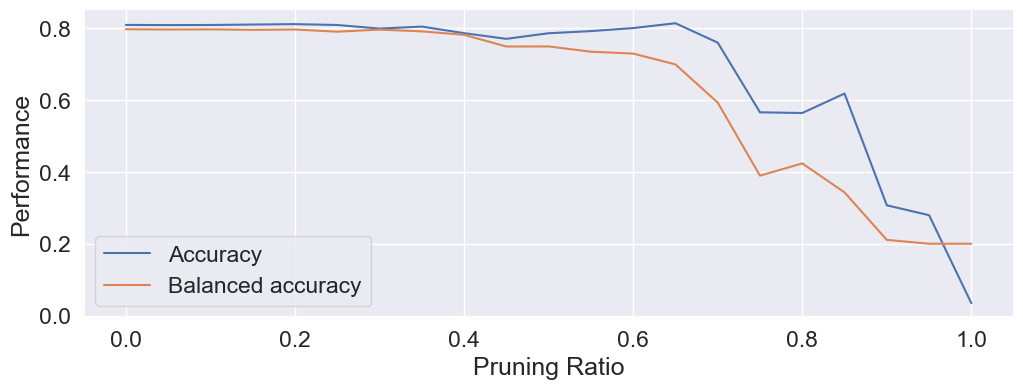

In [97]:
plt.figure(figsize=(12, 4))
plt.plot(np.linspace(0.0, 1.0, 21), accuracy, label='Accuracy')
plt.plot(np.linspace(0.0, 1.0, 21), balanced_acc, label='Balanced accuracy')

plt.xlabel('Pruning Ratio')
plt.ylabel('Performance')
plt.legend()
plt.show()

In [101]:
latent_representations_train, pred_train, prob_train, ttrain, eq_train  = run_inference(loaders['train'], model)
latent_representations_val, pred_val, prob_val, tval, eq_val            = run_inference(loaders['val'], model)
latent_representations_test, pred_test, prob_test, _, _                 = run_inference(loaders['test'], model)

print(f"\nTrain accuracy: {eq_train.mean()}")
print(f"Validation accuracy: {eq_val.mean()}")

100%|██████████| 168/168 [00:01<00:00, 107.86it/s]


Train accuracy: 0.9632394366197183
Validation accuracy: 0.8084704102854982


In [121]:
def visualize_utility(ax, U, labels=None):
    
    num_classes = len(U)
    
    ax.imshow(U, cmap=plt.cm.Greys_r, alpha=0.5)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    
    if labels:
        ax.set_xticklabels(labels, rotation=25)
        ax.set_yticklabels(labels)
    
    ax.grid(False)
    
    for (j,i), val in np.ndenumerate(U):
        ax.text(i,j, val, ha='center', va='center', fontsize=16)
    ax.set_title('Utility matrix', fontweight='bold')
    
def visualize_confusion_matrix(fig, ax, cm_, reg_type, dtype):
    idx2label   = {0: 'Other', 1: 'Music', 2: 'Human voice', 3: 'Engine sounds', 4: 'Alarm'}

    # Plot confusion matrix as heatmap
    sns.heatmap(cm_, annot=True, cmap='Blues', ax=ax)

    # Set ticks
    ticks = list(zip(*[(i + 0.5, name_) for i, name_ in idx2label.items()]))
    ax.set_xticks(ticks[0], ticks[1], rotation=25)
    ax.set_yticks(ticks[0], ticks[1], rotation=0)

    # Set labels and title
    ax.set_ylabel('True class')
    ax.set_xlabel('Predicted class')
    ax.set_title(f"Confusion matrix: {dtype}", weight='bold')
    fig.suptitle(f'{reg_type}', weight='bold')
    return fig, ax

In [122]:
U = np.identity(5)

# computing the expected utility for each class
EU_train = prob_train @ U
EU_val = prob_val @ U

# not one hot
U_ttrain = EU_train.argmax(axis=1)
U_tval = EU_val.argmax(axis=1)

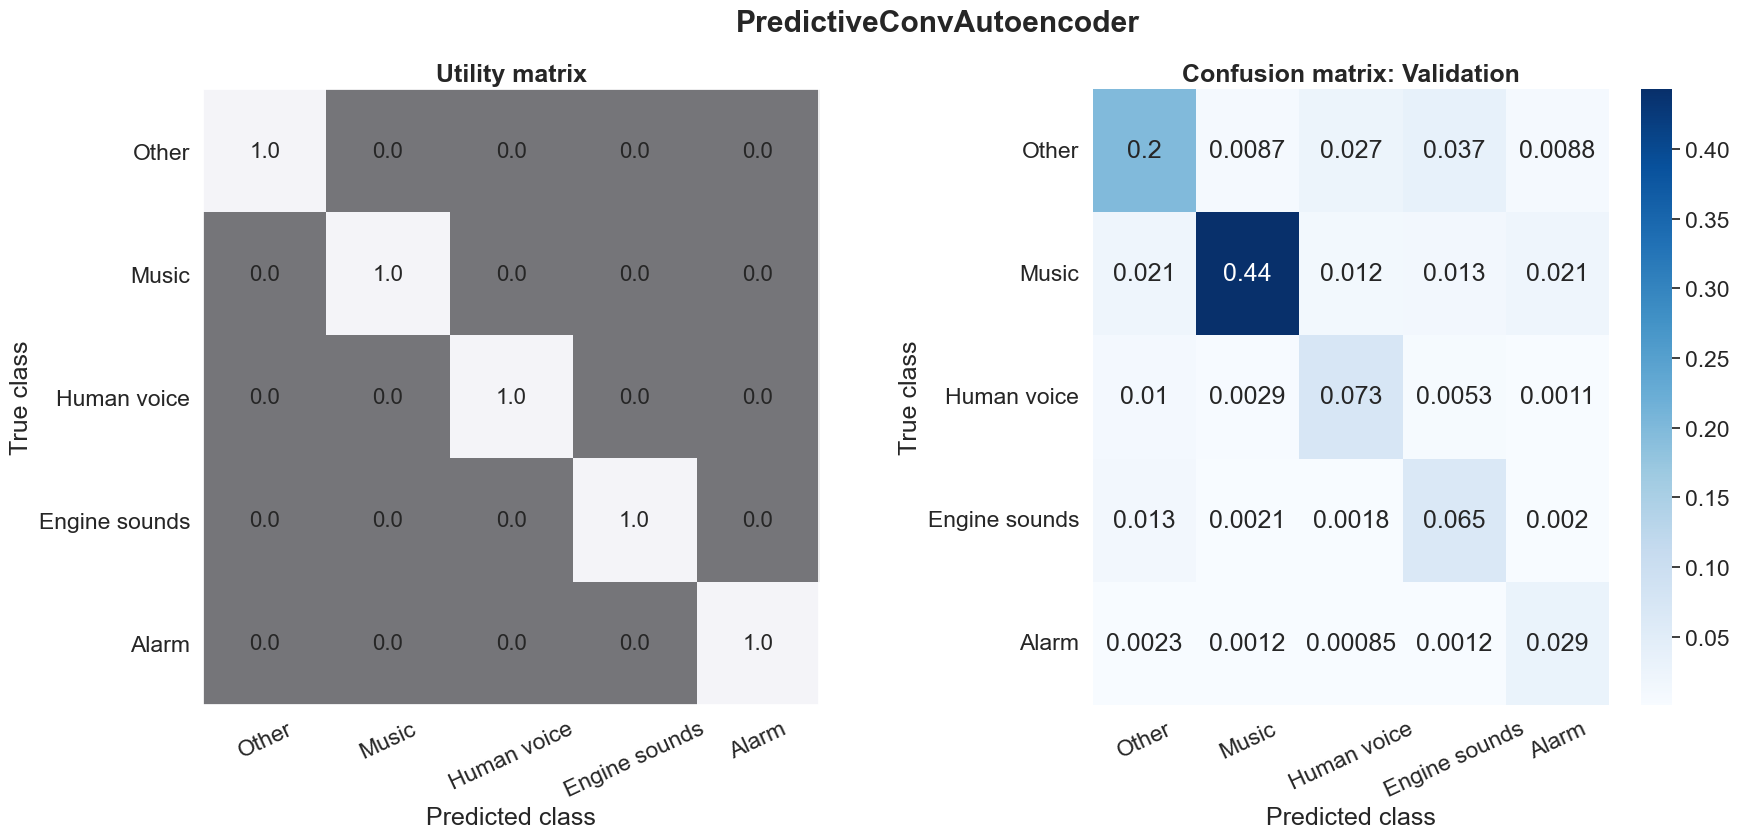

In [123]:
idx2label   = {0: 'Other', 1: 'Music', 2: 'Human voice', 3: 'Engine sounds', 4: 'Alarm'}

# plot everything
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# utility matrix
visualize_utility(axes[0], U, labels=idx2label.values())

# plotting the new confusion matrix
cm = confusion_matrix(tval, U_tval, normalize='all')
fig, axes[1] = visualize_confusion_matrix(fig, axes[1], cm, checkpoint['model']['name'], 'Validation')

#fig.tight_layout()
#fig.subplots_adjust(hspace=10)
fig.subplots_adjust(wspace=0.4)
plt.show()

In [165]:
num_classes     = 5

design_matrix   = lambda x: np.column_stack((np.ones(len(x)), x))
# design_matrix   = lambda x: np.column_stack((np.ones(len(x)), x, x**2))
# design_matrix   = lambda x: np.column_stack((np.ones(len(x)), x, x**2, x**3, x**4))
one_hot_encode  = lambda t: np.eye(num_classes)[t] 

# define softmax
softmax = lambda y: np.exp(y) / np.exp(y).sum(axis=1)[:, np.newaxis]

def predict(Phi: np.ndarray, theta: np.ndarray) -> (np.ndarray, np.ndarray):
    # get latent function value
    y = Phi @ theta
    # get soft probabilty scores
    prob = softmax(y)
    # get topk predictions
    pred = prob.argmax(axis=1)

    return pred, prob

In [166]:
# Create design matrices
Phi_train       = design_matrix(latent_representations_train)
Phi_val         = design_matrix(latent_representations_val)
Phi_test        = design_matrix(latent_representations_test)

# Number of parameters
n_params        = Phi_train.shape[1]

# One-of-K encode targets
ttrain_enc      = one_hot_encode(targets_train.cpu())
tval_enc        = one_hot_encode(targets_val.cpu())

# Get least squares solution
theta_hat_LS = np.linalg.solve(Phi_train.T @ Phi_train, Phi_train.T @ ttrain_enc) 

# Get LS predictions 
ttrain_hat_LS, ttrain_prob_LS       = predict(Phi_train, theta_hat_LS)
tval_hat_LS, tval_prob_LS           = predict(Phi_val, theta_hat_LS)

In [167]:
print("\n--- LS ESTIMATE OBTAINED ---")
print(f"Accuracy train: {(ttrain_hat_LS == targets_train.cpu().numpy()).mean():.4f}")
print(f"Accuracy validation: {(tval_hat_LS == targets_val.cpu().numpy()).mean():.4f}")
print(f"Balanced accuracy train: {balanced_accuracy_score(targets_train.cpu().numpy(), ttrain_hat_LS):.4f}")
print(f"Balanced accuracy validation: {balanced_accuracy_score(targets_val.cpu().numpy(), tval_hat_LS):.4f}")


--- LS ESTIMATE OBTAINED ---
Accuracy train: 0.9556
Accuracy validation: 0.7823
Balanced accuracy train: 0.9556
Balanced accuracy validation: 0.7860


In [126]:
from sklearn.manifold import TSNE

idx2label   = {0: 'Other', 1: 'Music', 2: 'Human voice', 3: 'Engine sounds', 4: 'Alarm'}

tsne = TSNE(n_components=2)
projection_train = tsne.fit_transform(latent_representations_train.numpy(), targets_train.cpu().numpy())

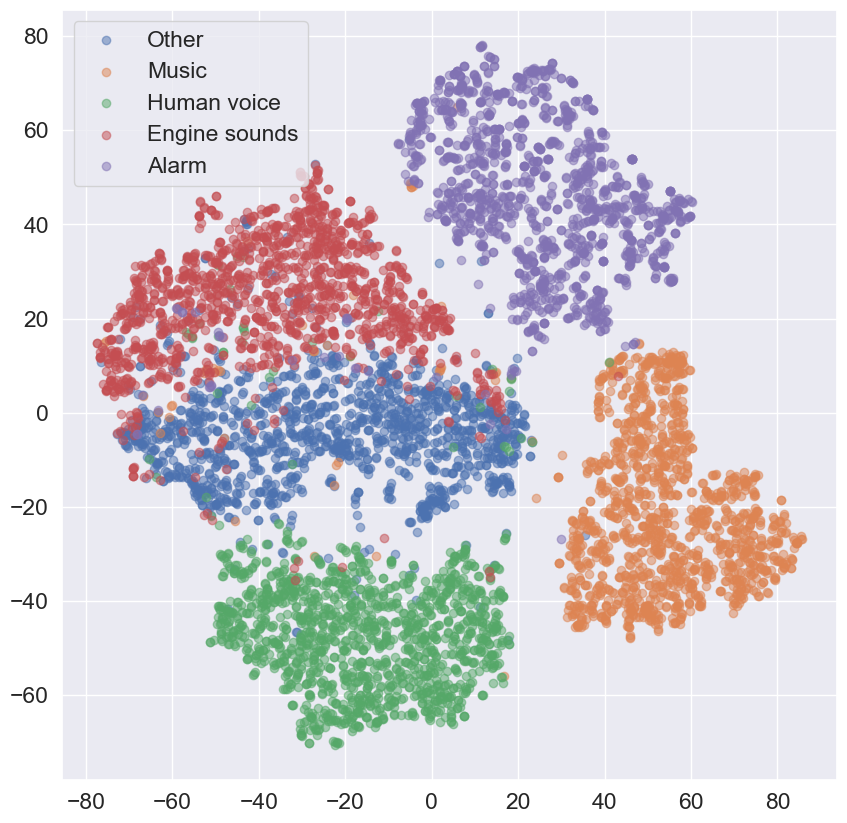

In [134]:
plt.figure(figsize=(10, 10))
for i in range(5):
    proj_ = projection_train[targets_train.cpu().numpy() == i, :]
    plt.scatter(proj_[:, 0], proj_[:, 1], alpha=0.5, label = idx2label[i])
    
plt.legend()
plt.show()

In [ ]:
fig = px.scatter_3d(
    Xtrain_pca[idx_samples], x=0, y=1, z=2, 
    color=np.array(ttrain_name)[idx_samples],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.update_traces(marker_size = 4)

fig.show()

In [138]:
import plotly.express as px

In [144]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_train = pca.fit_transform(latent_representations_train.numpy(), targets_train.cpu().numpy())

fig = px.scatter_3d(
    pca_train, x=0, y=1, z=2, 
    color=targets_train.cpu().numpy(),
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.update_traces(marker_size = 4)

import os
os.makedirs('../../figures/temporary', exist_ok=True)
fig.write_html("../../figures/temporary/pca.html")

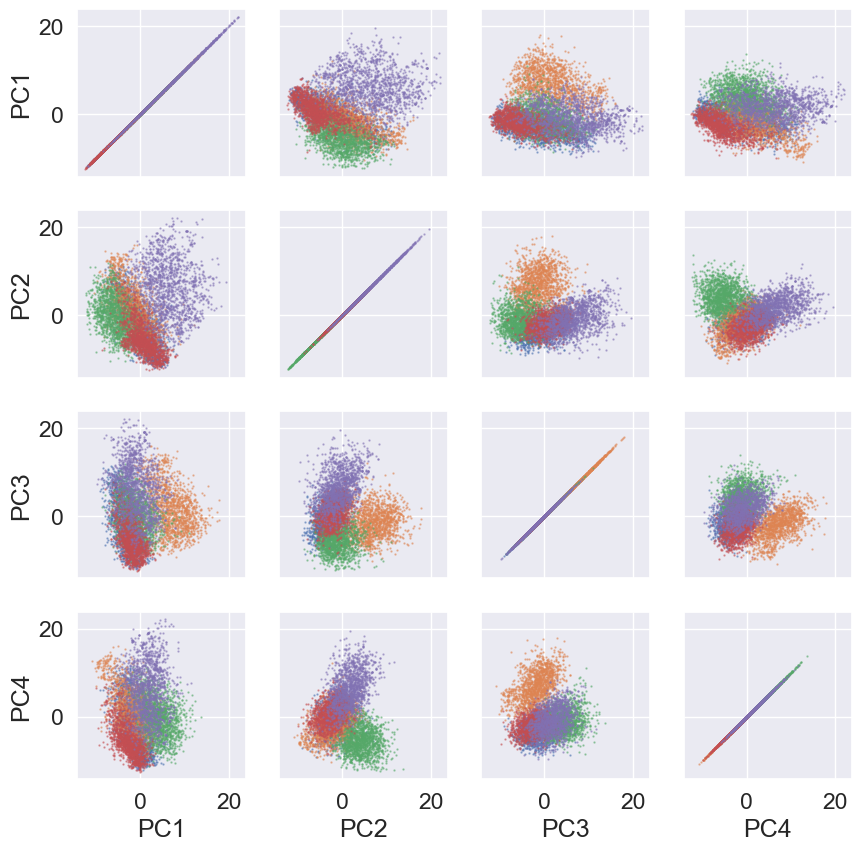

In [155]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca_train = pca.fit_transform(latent_representations_train.numpy(), targets_train.cpu().numpy())

fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10, 10))

for row in range(4):
    for col in range(4):
        if row == col:
            for i in range(5):
                proj_ = pca_train[targets_train.cpu().numpy() == i, :]
                axs[row, col].scatter(proj_[:, row], proj_[:, col], s=0.5, alpha=0.5, label = idx2label[i])
        else:
            for i in range(5):
                proj_ = pca_train[targets_train.cpu().numpy() == i, :]
                axs[row, col].scatter(proj_[:, row], proj_[:, col], s=0.5, alpha=0.5, label = idx2label[i])
        
        if row == 3:
            axs[row, col].set_xlabel(f'PC{col+1}')
        if col == 0:
            axs[row, col].set_ylabel(f'PC{row+1}')

# plt.legend()
plt.show()

In [135]:
projection_val = tsne.transform(latent_representations_val.numpy(), targets_val.cpu().numpy())

AttributeError: 'TSNE' object has no attribute 'transform'

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(5):
    proj_ = projection_train[targets_train.cpu().numpy() == i, :]
    plt.scatter(proj_[:, 0], proj_[:, 1], alpha=0.5, label = idx2label[i])
    
plt.legend()
plt.show()

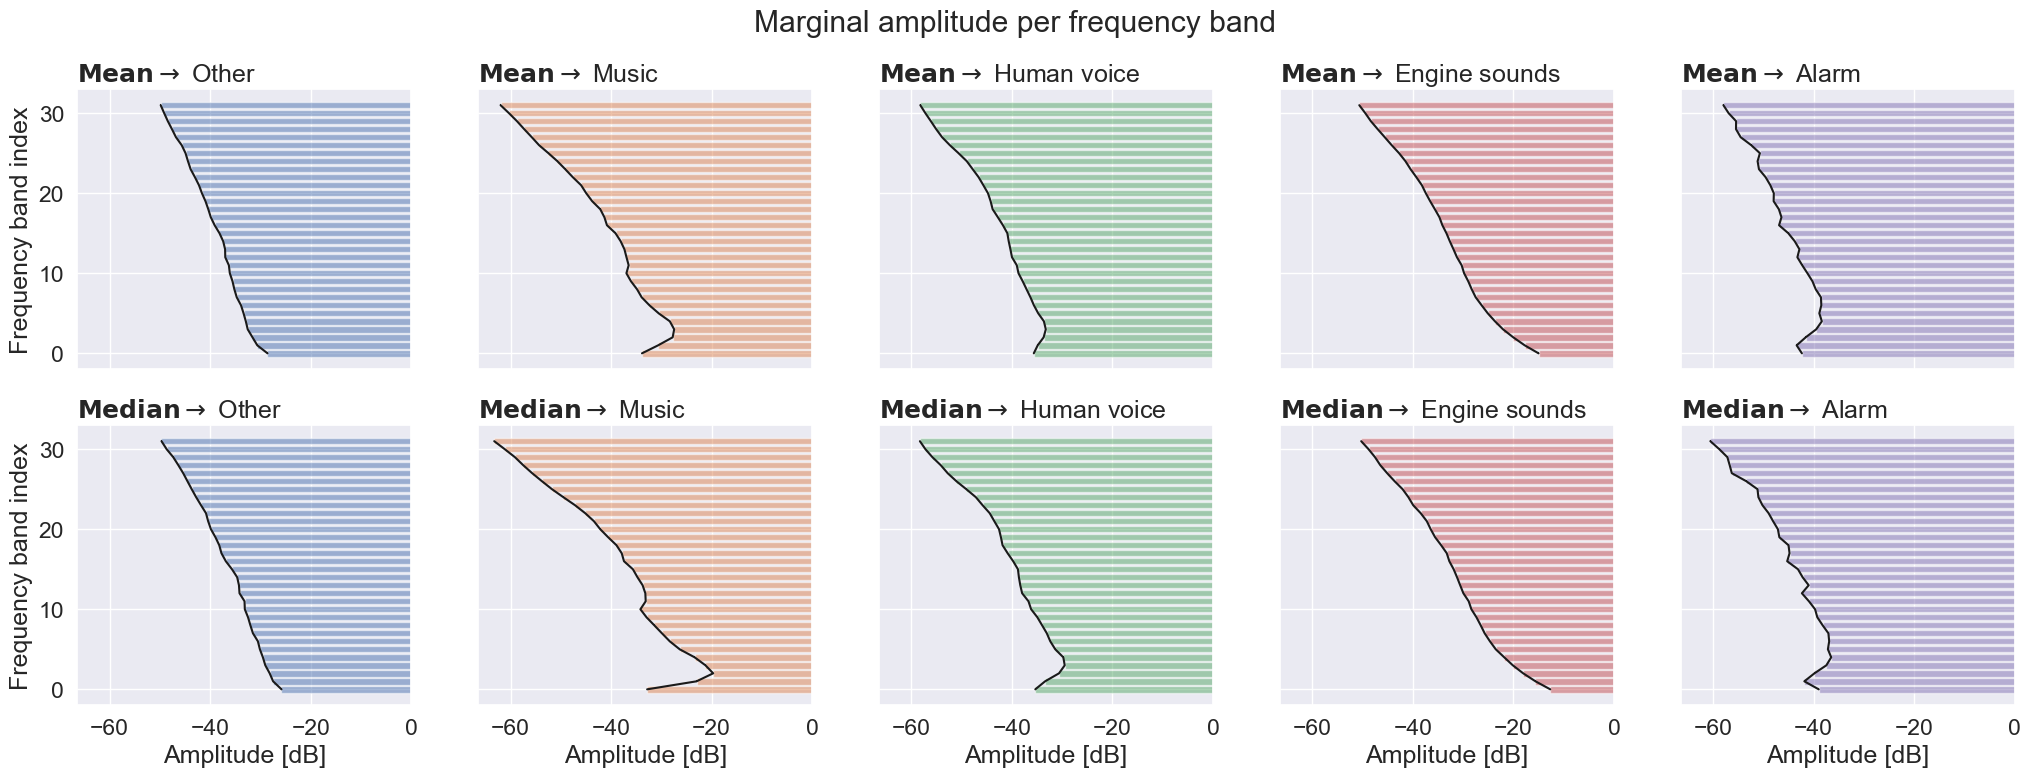

In [133]:
plot_marginal_frequency(Xtrain * sigma + mu, ttrain, num_classes=5)

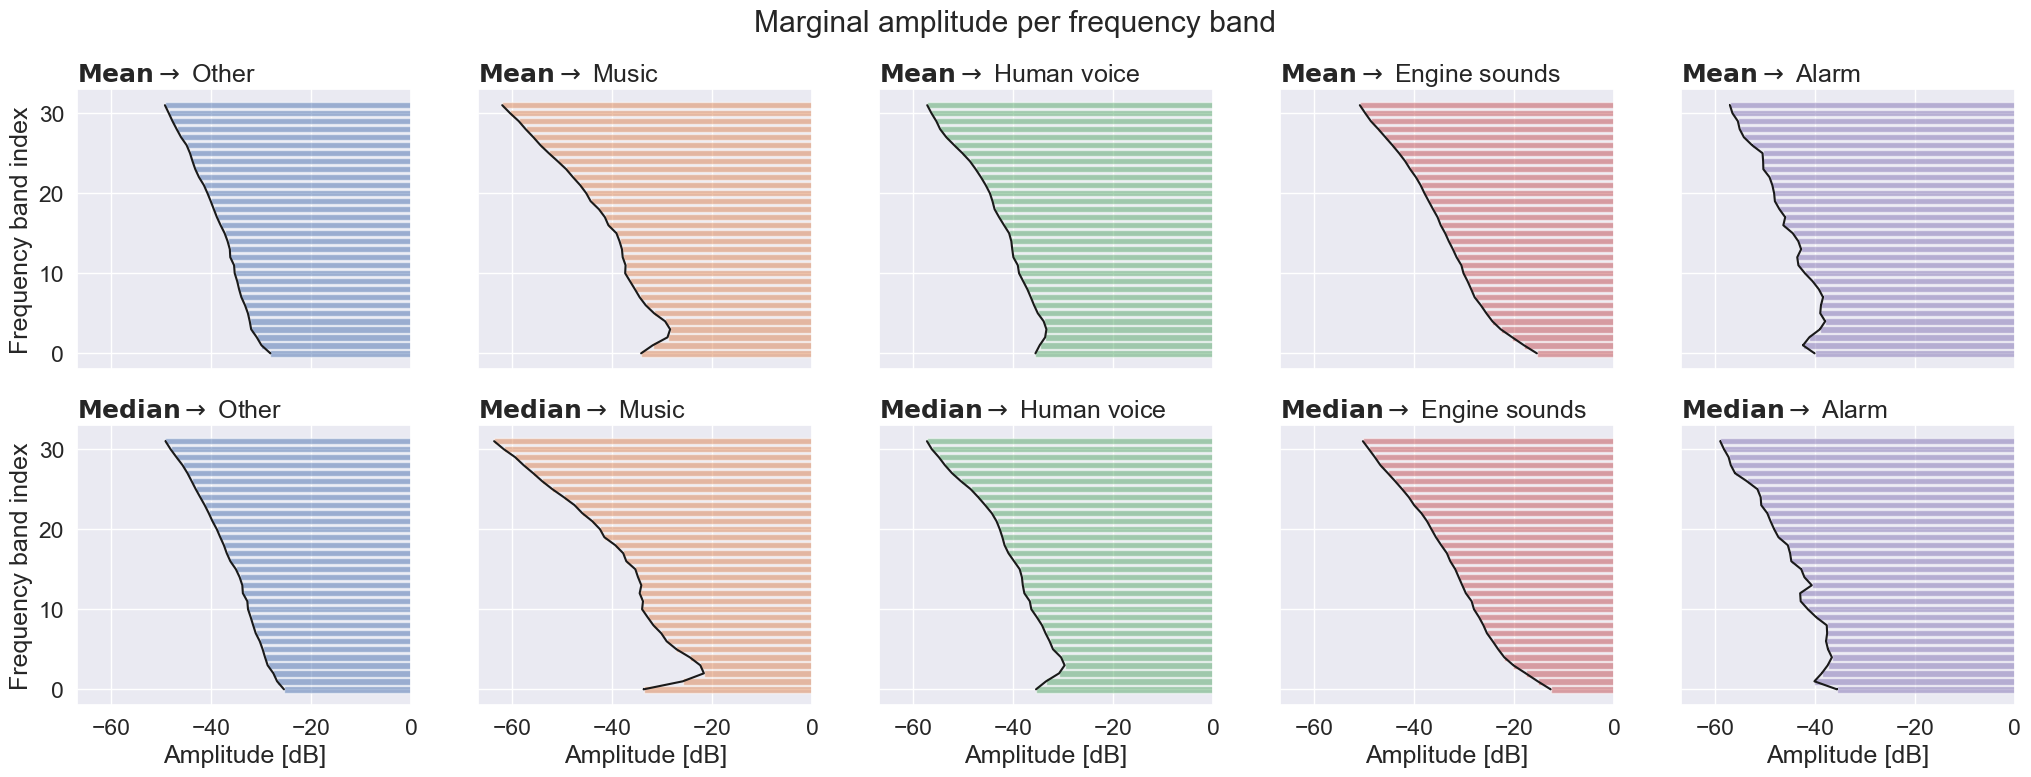

In [102]:
plot_marginal_frequency(Xval * sigma + mu, tval, num_classes=5)

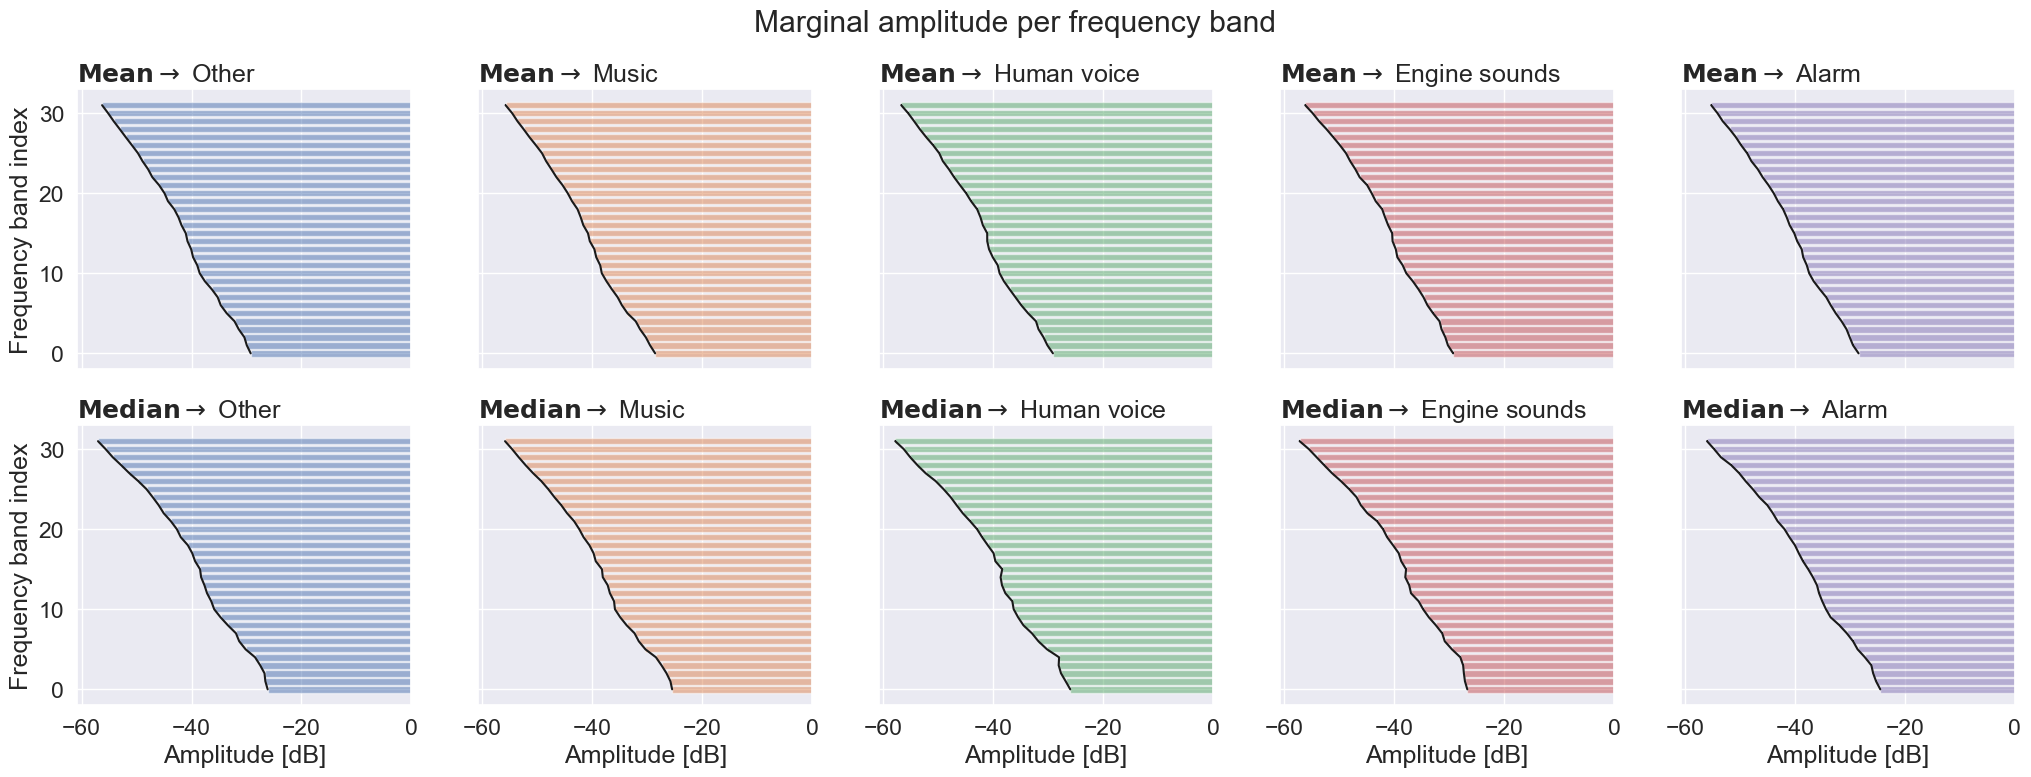

In [103]:
plot_marginal_frequency(Xtest * sigma + mu, ttest_hat, num_classes=5)